# Second Example: Image Denoising
  An autoencoder can also be trained to remove noise from images. In the following section, I will create a noisy version of the Fashion MNIST dataset by applying random noise to each image. Then train an autoencoder using the noisy image as input, and the original image as the target.

Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.datasets import fashion_mnist
from keras.models import Model


In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [3]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


In [4]:
# Adding Random noise to images
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)


x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

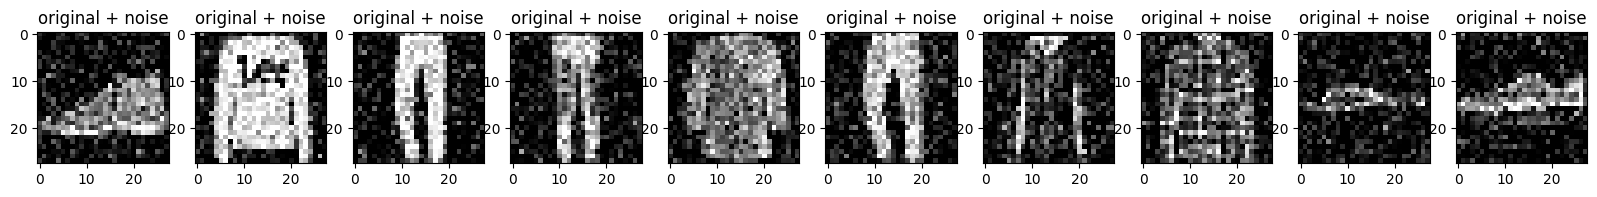

In [5]:
# plot
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

Define Convolution autoencoder:
  I will train a convolutional autoencoder using Conv2D layers in the encoder, and Conv2DTranspose layers in the decoder.

In [7]:
class denoise(Model):
    def __init__(self):
        super(denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
            keras.Input(shape=(28, 28, 1)),
            keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
            keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same',strides=2),
            
        ])
        
        self.decoder = tf.keras.Sequential([
           keras.layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
           keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
           keras.layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])
    

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
autoencoder = denoise()

In [9]:
autoencoder.compile(optimizer='adam', loss=keras.losses.MeanSquaredError())

In [10]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - loss: 0.0330 - val_loss: 0.0092
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 36s 19ms/step - loss: 0.0088 - val_loss: 0.0083
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 42s 19ms/step - loss: 0.0081 - val_loss: 0.0078
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 34s 18ms/step - loss: 0.0077 - val_loss: 0.0076
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 33s 18ms/step - loss: 0.0074 - val_loss: 0.0073
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 33s 18ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 40s 17ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 34s 18ms/step - loss: 0.0071 - val_loss: 0.0070
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 44s 23ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - loss: 0.0070 - val_loss: 0.0070


In [11]:
autoencoder.encoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 8)        │         1,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,320 (5.16 KB)

 Trainable params: 1,320 (5.16 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
autoencoder.decoder.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_transpose                │ (32, 14, 14, 8)        │           584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (32, 28, 28, 16)       │         1,168 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 28, 28, 1)        │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,897 (7.41 KB)

 Trainable params: 1,897 (7.41 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

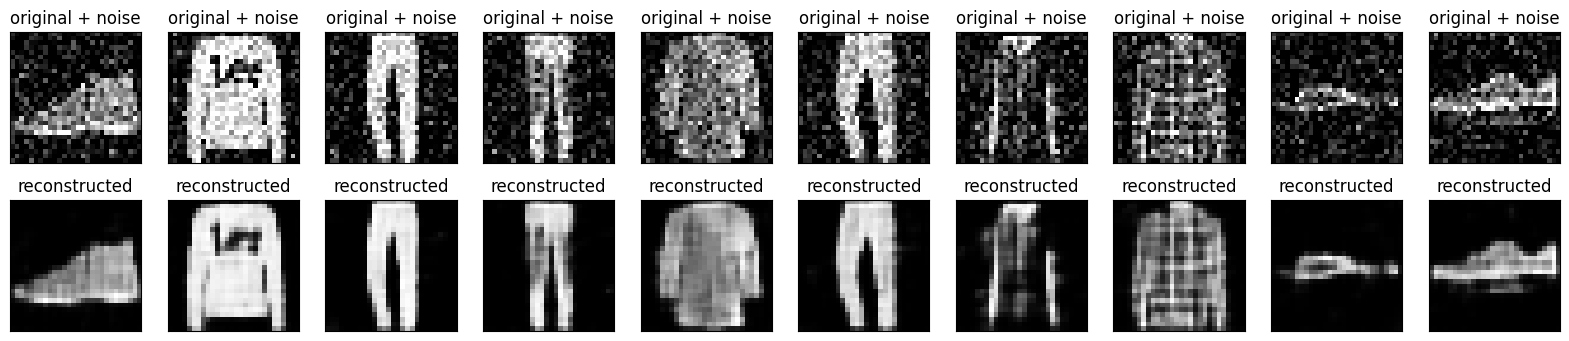

In [14]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

In [15]:
# Evaluate the autoencoder using thresholded (binarized) images
x_test_bin = (x_test > 0.5).astype(int)
decoded_bin = (decoded_imgs > 0.5).astype(int)
print("Accuracy:", accuracy_score(x_test_bin.flatten(), decoded_bin.flatten()))     
print("Precision:", precision_score(x_test_bin.flatten(), decoded_bin.flatten(), average='macro', zero_division=0))
print("Recall:", recall_score(x_test_bin.flatten(), decoded_bin.flatten(), average='macro', zero_division=0))


Accuracy: 0.9562701530612245
Precision: 0.9496810122849877
Recall: 0.9489607979260072
